# Algotytm przecinania się odcinków na płaszczyźnie

### Wprowadzenie
Celem ćwiczenia jest implementacja i zapoznanie się z algorytmem wyznaczającym wszystkie przecięcia się odcinków na płaszczyźnie

In [153]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [154]:
import numpy as np
import matplotlib.pyplot as plt
from tests.test4 import Test
from visualizer.main import Visualizer
from enum import Enum
from time import time, sleep
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os


# Generowanie zbiorów na potrzeby testów

### Zbiór A
Zbiór do wykazania, że algorytm zamiatania jest dużo lepszy od naiwnego podejścia

In [155]:
def generate_set_a(n = 10, max_y = 100, min_y = 0, incline_change = -10, min_x = 0, max_x = 100):
    dy = (max_y - min_y)/n
    result = []
    current_y = max_y
    while current_y > min_y:
        pl = (min_x,current_y)
        pr = (max_x,current_y+incline_change)
        result.append((pl,pr))
        current_y -= dy
    return result

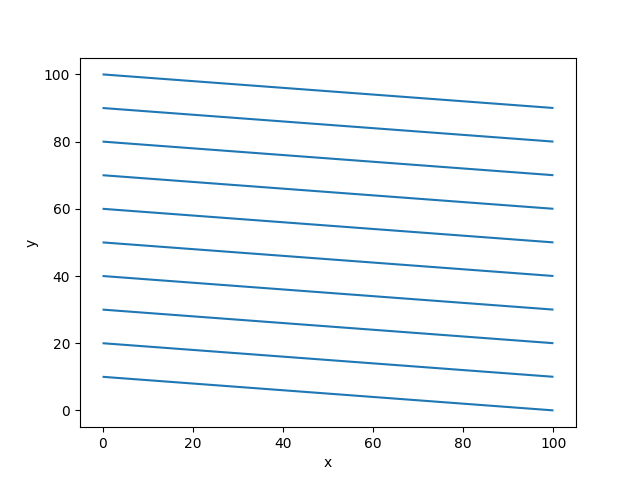

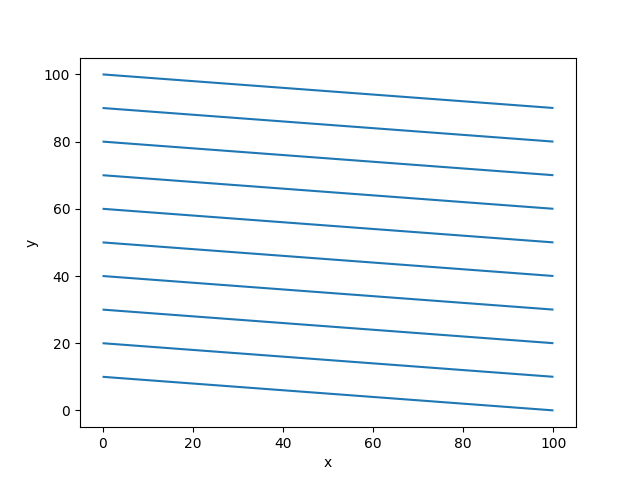

In [156]:
vis = Visualizer()
sections = generate_set_a()
vis.add_line_segment(sections)
vis.show()
vis.save("Zbiór_A")

### Zbiór B
Zbiór do przedstawienia nieprzyjemnego przypadku dla algorytmu zamiatania, gdzie P = O(n^2)

In [157]:
def generate_set_b(n=10):
    max_y, min_y = 100,0
    incline_change = -10
    min_x,xr_o = 0,100
    max_x = xr_o
    result = []
    current_y = max_y
    dx = (min_x - max_x)/(2*n)
    d = dx
    eps = 1e-10
    for i in range(n):
        pl = (min_x,current_y)
        pr = (max_x,current_y+incline_change)
        result.append((pl,pr))
        min_x += dx
        max_x -= dx * i
        if abs((min_x - max_x)/2) < eps:
            # Generated a vertical line, quit now
            print(i)
            break

    return result

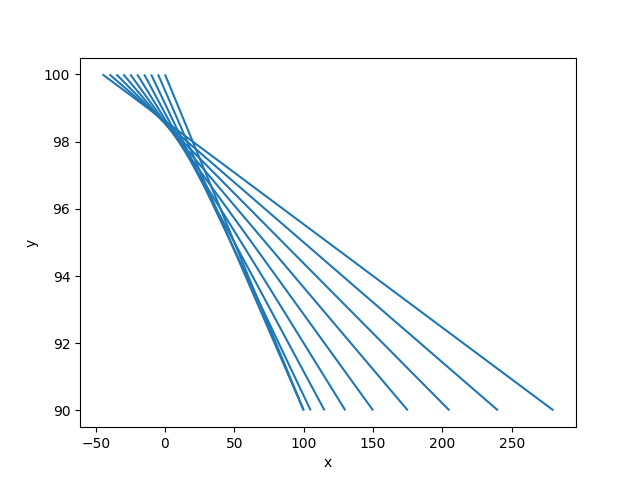

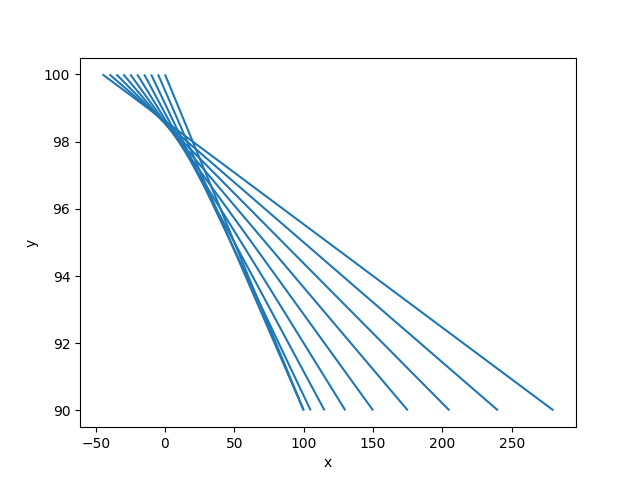

In [158]:
vis = Visualizer()
sections = generate_set_b(10)
vis.add_line_segment(sections)
vis.show()
vis.save("Zbiór_B")

### Zbiór C
Zbiór do testowania ilości przecięć dla P rzędu n

In [159]:
def generate_set_c(n = 10, max_y = 100, min_y = 0, incline_change = -10, min_x = 0, max_x = 100):
    result = generate_set_a(n-1)
    result.append(((min_x,min_y-abs(incline_change)),(max_x,max_y+abs(incline_change))))
    return result

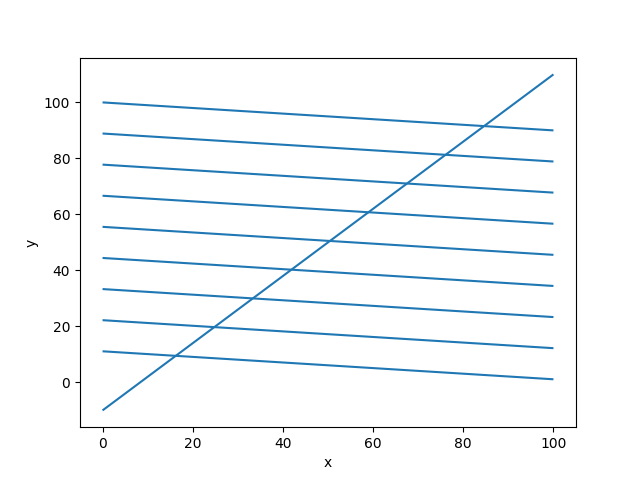

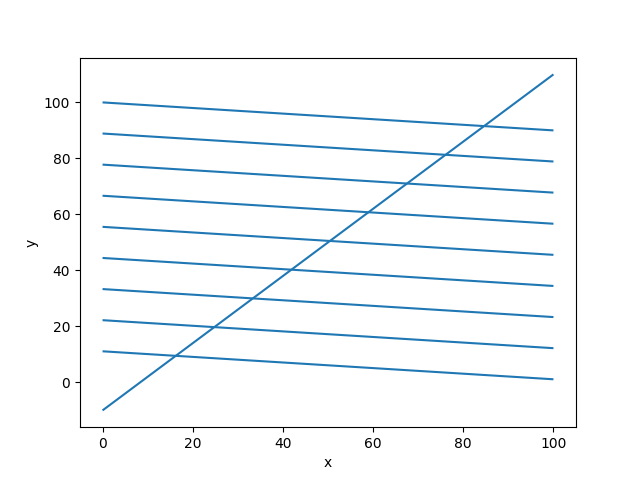

In [160]:
vis = Visualizer()
sections = generate_set_c(10)
vis.add_line_segment(sections)
vis.show()
vis.save("Zbiór_C")

### Zbiór D

In [161]:
def generate_set_d(n=10, max_y = 100, min_x = 0, max_x = 100, incline_change = -100):

    result = []
    current_y = max_y
    dx = (min_x - max_x)/(2*n)
    d = dx
    eps = 1e-10
    for i in range(n):
        pl = (min_x,current_y)
        pr = (max_x,current_y+incline_change)
        result.append((pl,pr))
        min_x += dx
        max_x -= dx
        if abs((min_x - max_x)/2) < eps:
            # Generated a vertical line, quit now
            print(i)
            break

    return result

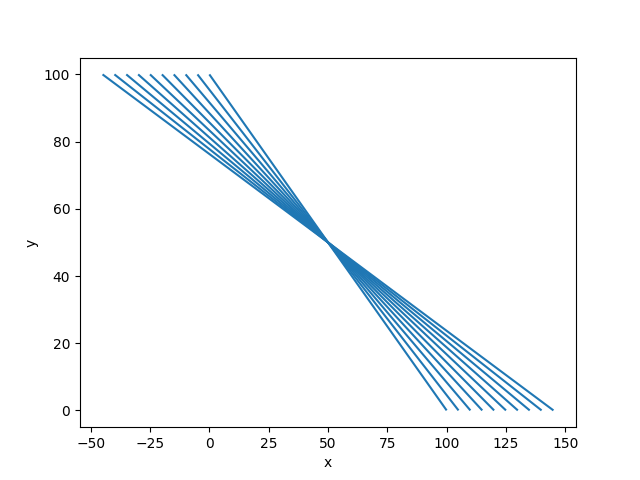

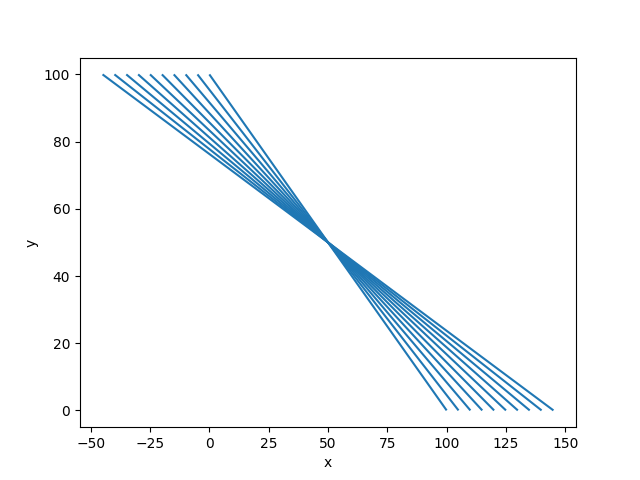

In [162]:
vis = Visualizer()
sections = generate_set_d(10)
vis.add_line_segment(sections)
vis.show()
vis.save("Zbiór_D")

### Zbiór E

In [163]:
from random import uniform, randint
def generate_set_e(n=10,max_x=100, max_y=100):
    result = []
    for _ in range(n):
        x1 = uniform(0,max_x)
        y1 = uniform(0,max_y)
        x2 = uniform(0,x1) if randint(0,1) == 1 else uniform(x1,max_x)
        y2 = uniform(0,max_y)
        result.append(((x1,y1),(x2,y2)))
    return result

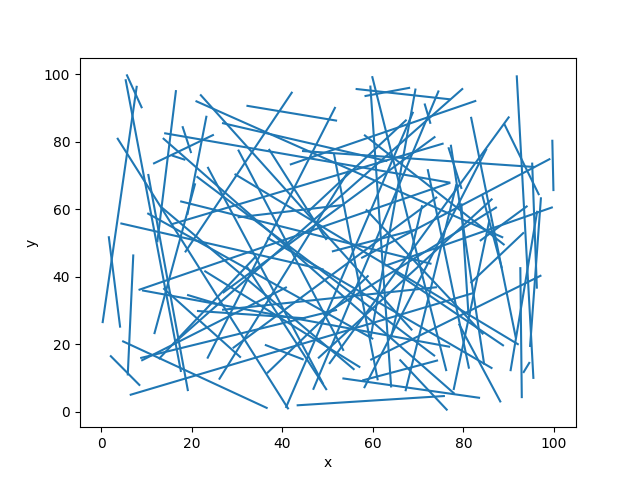

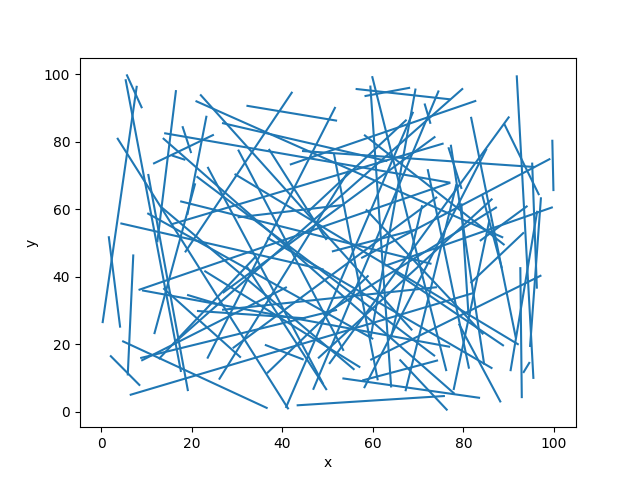

In [164]:
vis = Visualizer()
sections = generate_set_e(100,100,100)
vis.add_line_segment(sections)
vis.show()
vis.save("Zbiór_E")

# Przydatne funkcje 

### Wpisywanie wyników testów czasowych do tabeli do pliku LaTeX

In [165]:
def create_tex_table(table_name,data):
    
    latex_template = r"""
\begin{table}[H]
    \renewcommand{\tablename}{Tabela}

    \centering
    \small
    \caption{Tabela różnic czasów obliczeń}
    \resizebox{\textwidth}{!}{
    \begin{tabular}{@{}lllc@{}}
        \toprule
                Ilość odcinków & Algorytm brutalny &  Algorytm z drzewem & Ilość przecięć 
        \\ \midrule
"""
    
    def wrap(number):
        return str(round(number,4)).replace('.',',')
    for row in data:
        value_brut = row['brut']
        value_tree = row['tree']
        unit_brut = ' \\mu s'
        unit_tree = ' \\mu s'
        if int(value_brut) >= 1000:
            unit_brut = ' ms'
            value_brut /= 1000
        if int(value_tree) >= 1000:
            unit_tree = ' ms'
            value_tree /= 1000
        if int(value_brut) >= 1000:
            unit_brut = ' s'
            value_brut /= 1000
        if int(value_tree) >= 1000:
            unit_tree = ' s'
            value_tree /= 1000

        brut_time = wrap(value_brut) + unit_brut
        tree_time = wrap(value_tree) + unit_tree
        latex_template += f"        {row['segments']} & {brut_time} & {tree_time} & {row['cuts']}\\\\ \n"

    latex_template += r"""        \bottomrule
    \end{tabular}
}
    \label{table:generator4}
    \small
    \normalsize
\end{table}
"""

    output_filename = f"{table_name}.tex"
    with open(output_filename, "w") as f:
        f.write(latex_template)

    print(f"LaTeX table has been written to {output_filename}")

### Wpisywanie do pliku CSV

In [166]:
def csv_dump(table_name,data):
    
    content = "Ilość odcinków;Algorytm brutalny;Algorytm z drzewem; Ilość przecięć\n"
    
    def wrap(number):
        return str(round(number,4)).replace('.',',')
    for row in data:
        value_brut = row['brut']
        value_tree = row['tree']
        unit_brut = ' mikro s'
        unit_tree = ' mikro s'
        if int(value_brut) >= 1000:
            unit_brut = ' ms'
            value_brut /= 1000
        if int(value_tree) >= 1000:
            unit_tree = ' ms'
            value_tree /= 1000
        if int(value_brut) >= 1000:
            unit_brut = ' s'
            value_brut /= 1000
        if int(value_tree) >= 1000:
            unit_tree = ' s'
            value_tree /= 1000
        brut_time = wrap(value_brut) + unit_brut
        tree_time = wrap(value_tree) + unit_tree
        content = content + f"{row['segments']};{brut_time};{tree_time};{row['cuts']}\n"
    output_filename = f"{table_name}.csv"
    with open(output_filename, "w") as f:
        f.write(content)

    print(f"CSV data table has been written to {output_filename}")

### Przykładowy zbiór odcinków przed wyznaczeniem punktów przecięcia

In [167]:
def draw_example_1():
    vis = Visualizer()
    line_segments = generate_set_a()

    vis.add_line_segment(line_segments)
    vis.show()
    
def draw_example_2():
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))
    points = [(4, 2),
              (2.5, 3.5),
              (5.5, 4.5)]

    vis.add_line_segment(line_segments)
    vis.add_point(points, color='red')
    vis.show()


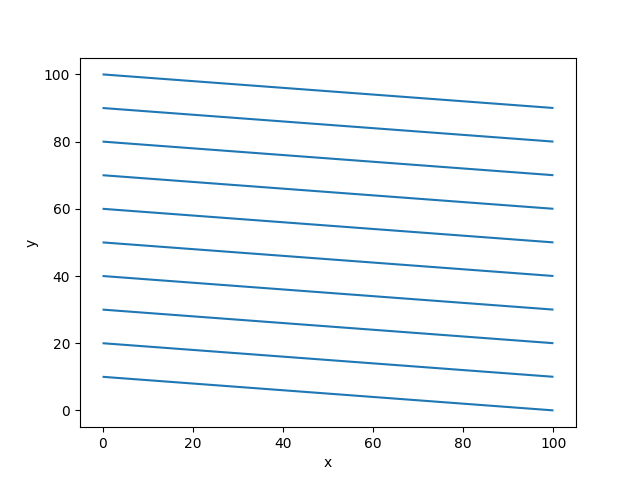

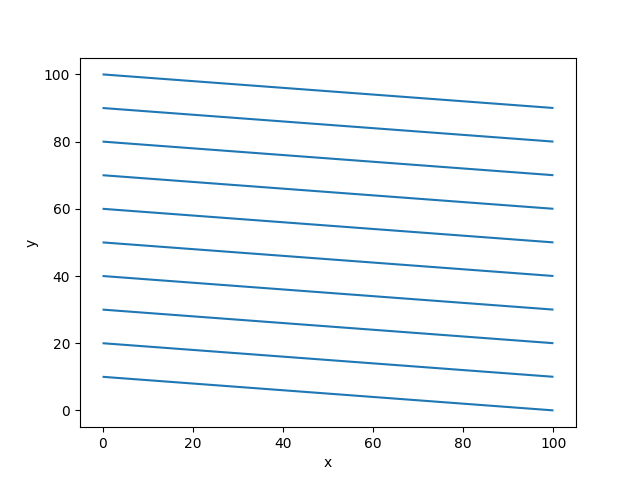

In [168]:
draw_example_1()

### Przykładowy zbiór odcinków po wyznaczenu punktów przecięcia

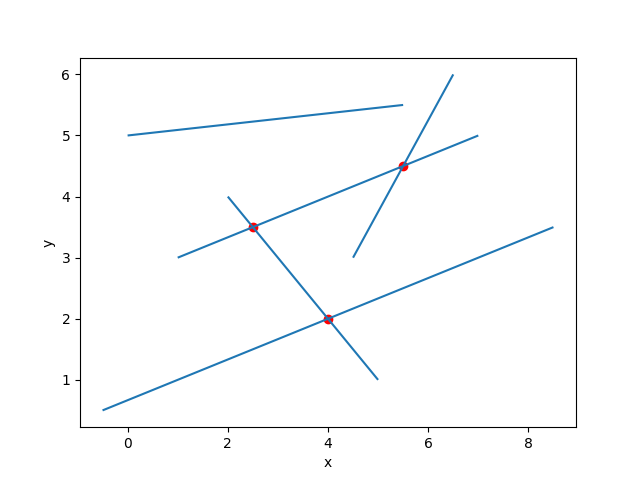

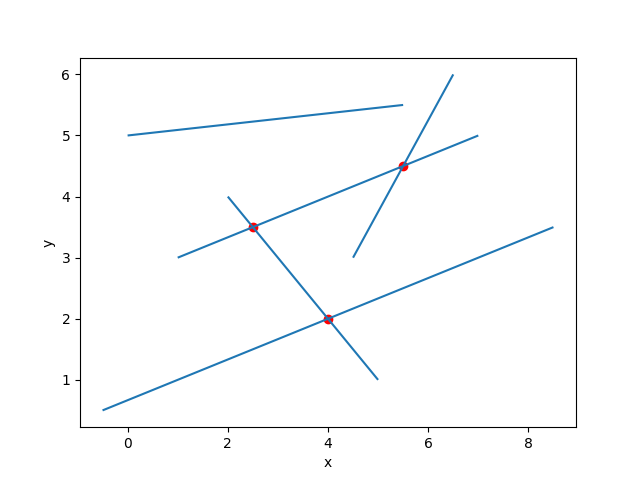

In [169]:
draw_example_2()

### Wizualizacja pojedynczej klatki algorytmu

In [170]:
def draw_state(sections,current,points,events,current_point):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    dy = 1e-5

    # Wszystkie odcinki
    for section in sections:
        x_vals, y_vals = [section[0][0], section[1][0]], [section[0][1], section[1][1]]
        ax.plot(x_vals, y_vals, color='blue', zorder=1, lw=1)

    # Odcinki aktywne
    for section in current:
        x_vals, y_vals = [section[0][0], section[1][0]], [section[0][1], section[1][1]]
        ax.plot(x_vals, y_vals, color='red', zorder=1, lw=1)

    # Punkty punkty obsłużone
    for (x, y,_) in points:
        ax.scatter(x, y, color='red', zorder=1, label=f'Punkty obsłużone')

    # Punkty zdarzeń
    for (x,y,_) in events:
        ax.scatter(x, y, color='green', zorder=1, label=f'Punkty zdarzeń')
    
    # Miotła
    ax.axline((current_point.x,current_point.y),(current_point.x,current_point.y+dy), color='red', label="Miotła")

    ax.autoscale()
    plt.show()

### Wyznaczanie, czy 4 punkty tworzące odcinek się przecinają

In [171]:
E = 1e-18

def det(a,b,c):
    return (b[0] - a[0]) * (c[1] - b[1]) - (b[1] - a[1]) * (c[0] - b[0])

def side(a,b,c):
    d = det(a,b,c)
    return 1 if d > E else (-1 if d < -E else 0)

def in_segment(a, b, c):
    if a[0] < b[0]:
        return a[0] <= c[0] and c[0] <= b[0]
    if b[0] < a[0]:
        return b[0] <= c[0] and c[0] <= a[0]

    if a[1] < b[1]:
        return a[1] <= c[1] and c[1] <= b[1]
    if b[1] < a[1]:
        return b[1] <= c[1] and c[1] <= a[1]
    return a[0] == c[0] and a[1] == c[1]

def is_intersection(a,b,c,d):
    if a == b:
        return a == c or a == d
    if c == d:
        return c == a or c == b
    s1 = side(a,b,c)
    s2 = side(a,b,d)
    if s1 == 0 and s2 == 0:
        return \
            in_segment(a, b, c) or in_segment(a, b, d) or \
            in_segment(c, d, a) or in_segment(c, d, b)
    if s1 and s1 == s2:
        return False
    s1 = side(c,d,a)
    s2 = side(c,d,b)
    if s1 and s1 == s2:
        return False
    return True

def is_intersection_segments(s1,s2):
    a,b,*_ = s1
    c,d,*_ = s2
    return is_intersection(a,b,c,d)


### Wyznaczanie punktu przecięcia i parametrów równania kierunkowego prostej

In [172]:

def get_parameters(section):
    P1,P2 = section
    x1,y1,*_ = P1
    x2,y2,*_ = P2
    if x1 == x2: # Should not be the case
        return (None,None)
    a = (y1-y2)/(x1-x2)
    b = y1 - a*x1
    return (a,b)

def get_intersection(section1,section2):
    a1,b1 = get_parameters(section1)
    a2,b2 = get_parameters(section2)
    if (a2 - a1) == 0:
        return (None,None)
    x = (b1-b2)/(a2-a1)
    y = a1*x+b1
    return (x,y)

# Generowanie losowych odcinków na płaszczyźnie

Uzupełnij funkcję ```generate_uniform_sections```

In [173]:
from random import uniform, randint
def generate_uniform_sections(max_x, max_y, n):
    """
    Funkcja generuje odcinki o współrzędnych rzeczywistych w postaci par punktów. 
    Żaden wygenerowany odcinek nie jest odcinkiem pionowym.
    Żadne dwa odcinki nie mają swoich końców o takiej samej współrzędnej x.
    Zakres współrzędnych: x -> (0, max_x), y -> (0, max_y)
    :param max_x: określa maksymalną wartość współrzednej x jaka może zostać wylosowana
    :param max_y: określa maksymalną wartość współrzednej y jaka może zostać wylosowana
    :param n: ilość generowanych odcinków
    :return: tablica odcinków w postaci krotek zawierających parę krotek współrzędnych punktów końcowych odcinków
    np. [((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)),...]
    """
    result = []
    for _ in range(n):
        x1 = uniform(0,max_x)
        y1 = uniform(0,max_y)
        x2 = uniform(0,x1) if randint(0,1) == 1 else uniform(x1,max_x)
        y2 = uniform(0,max_y)
        result.append(((x1,y1),(x2,y2)))
    return result

In [174]:
Test().runtest(1, generate_uniform_sections)

Lab 4, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.031s


<span style="color:red">Ćw.</span> Wygeneruj $\large20$ losowych odcinków w przestrzeni 2D o współrzędnych z przedziału $\large x \in \langle 0,1000 \rangle$ oraz $\large y \in \langle 0,1000\rangle$. 

In [175]:
section = generate_uniform_sections(1000,1000,20)

Zwizualizuj otrzymane odcinki

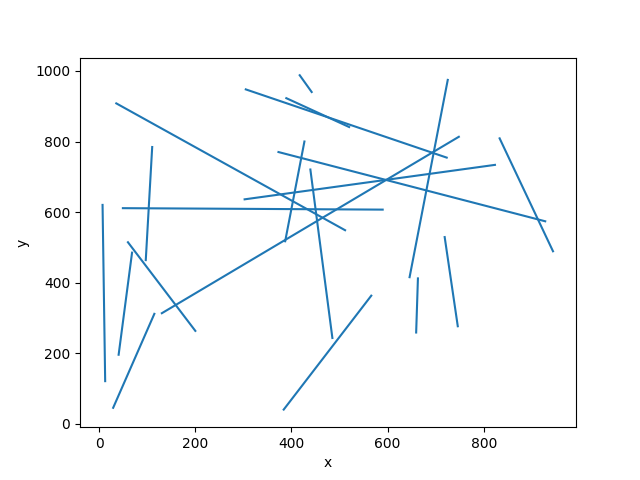

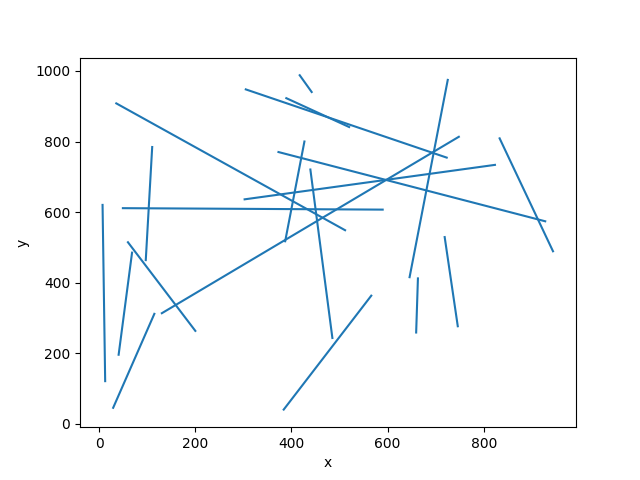

In [176]:
vis = Visualizer()

vis.add_line_segment(section)
vis.show()

# Zapisywanie odcinków do pliku

Potrzebne struktury do realizacji algorytmu

In [177]:
E = 1e-18
D = 1e-8

from typing import Self

class PointType(Enum):
    START = 0
    END = 1
    CROSS = 2

class Point:
    def __init__(self,x,y,line_index,point_type=PointType.START,other_line=None):
        self.x = x
        self.y = y
        self.line_index = line_index
        self.other_line = other_line
        self.point_type = point_type
    
    def __str__(self):
        # return f"({round(self.x,3)},{round(self.y,3)})"    
        return f"({self.x},{self.y})"
    
    def __eq__(self,other):
        if other is None or not isinstance(other,Point):
            return False
        return self.x == other.x
    
    def __hash__(self):
        return hash((self.x))
    
    def __lt__(self,other):
        if other is None or not isinstance(other,Point):
            return False
        if other == None:
            return False
        return self.x < other.x
    
    def __gt__(self,other):
        if other is None or not isinstance(other,Point):
            return False
        if other == None:
            return True
        return self.x > other.x
    
    def __le__(self,other):
        return self == other or self < other
    
    def __ge__(self,other):
        return self == other or self > other
    
    def greter(self, other, x):
        if (self.f(x) > other.f(x)):
            return self
        return other
    
    def smaller(self, other, x):
        if (self.f(x) < other.f(x)):
            return self
        return other
    def __iter__(self):
        # return iter(((self.x, self.y),self.line_index,self.other_line))
        return iter((self.x,self.y,(self.line_index,self.other_line)))
    def __getitem__(self,index):
        match index:
            case 0: 
                return self.x
            case 1:
                return self.y
            case 2:
                return self.point_type
            case 3:
                return self.line_index
            case 4:
                return self.other_line
            case _:
                raise IndexError("Point index out of range")

class LineSegment:
    # Statyczny x - dla każdej klasy dla ułatwienia porównań 
    x = 0
    def __init__(self,p1: Point,p2: Point,index):
        if p1 > p2:
            p1, p2 = p2, p1
        self.pl = p1
        self.pr = p2
        self.pl.point_type = PointType.START
        self.pr.point_type = PointType.END
        self.a, self.b = self.get_parameters(self.pl,self.pr)
        self.index = index
    
    def get_parameters(self,P1,P2):
        if P1 == P2:
            return (None,None)
        x1,y1 = P1.x,P1.y
        x2,y2 = P2.x,P2.y
        a = (y1-y2)/(x1-x2)
        b = y1 - a*x1
        return (a,b)
    
    def f(self):
        return self.a * LineSegment.x + self.b
        
    def __eq__(self, other: Self):
        if(other == None): return False
        return self.pl.x == other.pl.x and self.pl.y == other.pl.y and self.pr.x == other.pr.x and  self.pr.y == other.pr.y

    def __lt__(self, other: Self):
        if(other == None): return False
        return self.f()<other.f()    
    
    def __gt__(self, other: Self):
        if(other == None): return False
        return self.f()>other.f()
        
    def __hash__(self):
        return hash(((self.pl.x,self.pl.y), (self.pr.x,self.pr.y)))
  
    def __str__(self):
        return f"ID: {self.index} SP: {self.pl} EP: {self.pr} a: {self.a} b: {self.b}" 
   
    def in_segment(self,a, b, c):
        if a[0] < b[0]:
            return a[0] <= c[0] and c[0] <= b[0]
        if b[0] < a[0]:
            return b[0] <= c[0] and c[0] <= a[0]

        if a[1] < b[1]:
            return a[1] <= c[1] and c[1] <= b[1]
        if b[1] < a[1]:
            return b[1] <= c[1] and c[1] <= a[1]

        return a[0] == c[0] and a[1] == c[1]

    def intersects(self,other):
        a, b = self.pl,self.pr
        c, d = other.pl,other.pr
        return is_intersection(a,b,c,d)
    
    def __iter__(self):
        return iter((self.pl,self.pr))
    
    def __getitem__(self,index):
        match index:
            case 0: 
                return self.pr
            case 1:
                return self.pl
            case 2:
                return self.a
            case 3:
                return self.b
            case 4:
                return self.index
            case _:
                raise IndexError("Point index out of range")

Komórka poniżej generuje interaktywny obszar do wprowadzania odcinków. Punkt początkowy i końcowy odcinka wprowadzane są na zmianę

Button(description='Wyczyść punkty', style=ButtonStyle())

Button(description='Zapisz odcinki', style=ButtonStyle())

Button(description='Wczytaj punkty', style=ButtonStyle())

Output()

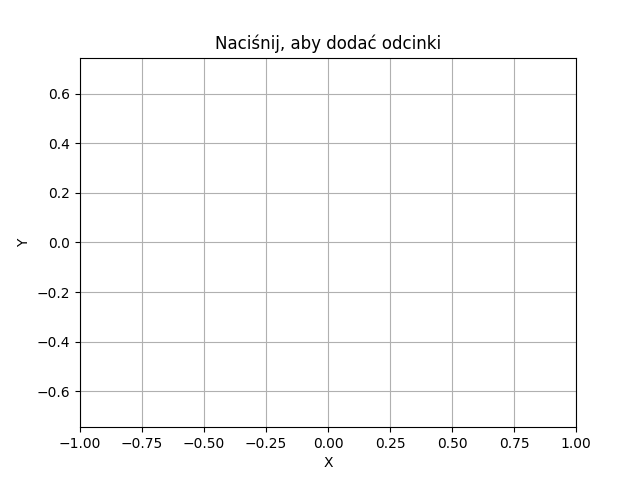

[((np.float64(0.0040322580645162365), np.float64(0.050000000000000044)), (np.float64(-0.6774193548387096), np.float64(-0.3008064516129032))), ((np.float64(0.375), np.float64(-0.13145161290322582)), (np.float64(0.2338709677419355), np.float64(0.2959677419354838))), ((np.float64(-0.33467741935483863), np.float64(-0.4096774193548387)), (np.float64(-0.6814516129032258), np.float64(0.21129032258064528))), ((np.float64(0.6693548387096775), np.float64(0.1508064516129033)), (np.float64(-0.7379032258064515), np.float64(-0.07903225806451608)))]
[((np.float64(-0.782258064516129), np.float64(0.42500000000000004)), (np.float64(0.9112903225806452), np.float64(-0.5508064516129032))), ((np.float64(-0.45967741935483863), np.float64(-0.3290322580645161)), (np.float64(0.8064516129032258), np.float64(0.48548387096774204))), ((np.float64(0.44758064516129026), np.float64(0.5983870967741935)), (np.float64(0.0), np.float64(-0.5548387096774193))), ((np.float64(0.7217741935483872), np.float64(0.610483870967742)

In [227]:
%matplotlib widget
import matplotlib.pyplot as plt
from ipywidgets import Button, Output, VBox
from ipywidgets import Button, Output, VBox
from matplotlib.figure import Figure
from IPython.display import display
import ast
points1 = []
points2 = []
limit = 4
output = Output()
fig, ax = plt.subplots()  # Create both figure and axis
canvas = fig.canvas # Use the Jupyter-compatible canvas
save_to_file = False
filename = "wyniki.txt"
state = True
previous_point = None
current_point = None
sections = []

def find_intersections_brut(sections):
    n = len(sections)    
    result = []
    start = time()
    segments = [LineSegment(Point(x1,y1,line_index=i),Point(x2,y2,line_index=i), index=i) for i, [(x1,y1), (x2,y2)] in enumerate(sections)]
    for i in range(n):
        for j in range(i+1, n):
            if(segments[i].intersects(segments[j])):
                result.append(get_intersection(segments[i],segments[j]))
    end = time()
    return result

def update_plot():
    global sections, points1, points2
    ax.clear()
    ax.set_title("Naciśnij, aby dodać odcinki")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True)
    ax.axis("equal")
    x_range = (-1, 1)
    y_range = (-1, 1)
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    if len(points1) > 0:
        x_coords, y_coords = zip(*points1)
        ax.scatter(x_coords, y_coords, color="red", s=10, label="Punkty początkowe")
    if sections:
        sections_1, sections_2 = zip(*sections)
        for i in range(len(sections_1)):
            x = (sections_1[i][0],sections_2[i][0])
            y = (sections_1[i][1],sections_2[i][1])
            ax.plot(x, y, color="blue")
        if len(points2) > 0:
            x_coords, y_coords = zip(*points2)
            ax.scatter(x_coords, y_coords, color="red", s=10, label="Punkty końcowe")
        interpoints = find_intersections_brut(sections)
        if len(interpoints) > 0:
            x_inter, y_inter, *_ = zip(*interpoints)
            ax.scatter(x_inter,y_inter,color="green",s=20,zorder=3,label="Punkty przecięć")
    canvas.draw_idle()

def onclick(event):
    global state,previous_point,current_point,sections,points1,points2
    if event.xdata is not None and event.ydata is not None:
        if state:
            previous_point = (event.xdata, event.ydata)
            points1.append(previous_point)
        else:
            current_point = (event.xdata, event.ydata)
            points2.append(current_point)
            sections.append((previous_point,current_point))
        state = not state
        # polygon.append((event.xdata, event.ydata))
        update_plot()


clear_button = Button(description="Wyczyść punkty")
save_button = Button(description="Zapisz odcinki")
load_button = Button(description="Wczytaj punkty")

def clear_points(button):
    global sections, points1, points2, state
    sections = []
    points1 = []
    points2 = []
    state = True
    update_plot()

def save_points(button):
    global sections
    result = []
    # for section in sections:
    #     result.append((np.float32(section[0][0]),np.float32(section[0][1]),(np.float32(section[1][0]),np.float32(section[1][1]))))
    with open("points.txt","w") as f:
        f.write(str(sections))
        print(sections)

def load_points(button):
    global sections, points1, points2
    lines = "" 
    try:
        with open("points.txt", "r") as f:
            lines = f.readline()

        lines = lines.replace("np.float64", "").replace("[", "").replace("]", "")
        sections_list = ast.literal_eval(lines)
        points1 = [ sec[0] for sec in sections_list ]
        points2 = [ sec[1] for sec in sections_list ]
        sections_tuple = sections_list
        sections = [ element for element in sections_tuple ]
        update_plot()
    except Exception as e:
        return f"Error reading or processing points: {e}"

clear_button.on_click(clear_points)
save_button.on_click(save_points)
load_button.on_click(load_points)
canvas.mpl_connect('button_press_event', onclick)

update_plot()
display(clear_button, save_button, load_button, output)
ui = VBox([clear_button, output, load_button, canvas])
display(ui)



Wyznacznik potrzebny do sprawdzenia, po której stronie prostej znajduje się punkt wraz z funkcją określającą stronę, po której jest punkt

# Sprawdzanie, czy istnieje przecięcie

### Klasy Point i LineSegment

Klasy przechowujące informacje na temat prezentowanych figur

In [179]:
E = 1e-18
D = 1e-8

from typing import Self

class PointType(Enum):
    START = 0
    END = 1
    CROSS = 2

class Point:
    def __init__(self,x,y,line_index,point_type=PointType.START,other_line=None):
        self.x = x
        self.y = y
        self.line_index = line_index
        self.other_line = other_line
        self.point_type = point_type
    
    def __str__(self):
        # return f"({round(self.x,3)},{round(self.y,3)})"    
        return f"({self.x},{self.y})"
    
    def __eq__(self,other):
        if other is None or not isinstance(other,Point):
            return False
        return self.x == other.x
    
    def __hash__(self):
        return hash((self.x))
    
    def __lt__(self,other):
        if other is None or not isinstance(other,Point):
            return False
        if other == None:
            return False
        return self.x < other.x
    
    def __gt__(self,other):
        if other is None or not isinstance(other,Point):
            return False
        if other == None:
            return True
        return self.x > other.x
    
    def __le__(self,other):
        return self == other or self < other
    
    def __ge__(self,other):
        return self == other or self > other
    
    def greter(self, other, x):
        if (self.f(x) > other.f(x)):
            return self
        return other
    
    def smaller(self, other, x):
        if (self.f(x) < other.f(x)):
            return self
        return other
    def __iter__(self):
        # return iter(((self.x, self.y),self.line_index,self.other_line))
        return iter((self.x,self.y,(self.line_index,self.other_line)))
    def __getitem__(self,index):
        match index:
            case 0: 
                return self.x
            case 1:
                return self.y
            case 2:
                return self.point_type
            case 3:
                return self.line_index
            case 4:
                return self.other_line
            case _:
                raise IndexError("Point index out of range")

class LineSegment:
    # Statyczny x - dla każdej klasy dla ułatwienia porównań 
    x = 0
    def __init__(self,p1: Point,p2: Point,index):
        if p1 > p2:
            p1, p2 = p2, p1
        self.pl = p1
        self.pr = p2
        self.pl.point_type = PointType.START
        self.pr.point_type = PointType.END
        self.a, self.b = self.get_parameters(self.pl,self.pr)
        self.index = index
    
    def get_parameters(self,P1,P2):
        if P1 == P2:
            return (None,None)
        x1,y1 = P1.x,P1.y
        x2,y2 = P2.x,P2.y
        a = (y1-y2)/(x1-x2)
        b = y1 - a*x1
        return (a,b)
    
    def f(self):
        return self.a * LineSegment.x + self.b
        
    def __eq__(self, other: Self):
        if(other == None): return False
        return self.pl.x == other.pl.x and self.pl.y == other.pl.y and self.pr.x == other.pr.x and  self.pr.y == other.pr.y

    def __lt__(self, other: Self):
        if(other == None): return False
        return self.f()<other.f()    
    
    def __gt__(self, other: Self):
        if(other == None): return False
        return self.f()>other.f()
        
    def __hash__(self):
        return hash(((self.pl.x,self.pl.y), (self.pr.x,self.pr.y)))
  
    def __str__(self):
        return f"ID: {self.index} SP: {self.pl} EP: {self.pr} a: {self.a} b: {self.b}" 
   
    def in_segment(self,a, b, c):
        if a[0] < b[0]:
            return a[0] <= c[0] and c[0] <= b[0]
        if b[0] < a[0]:
            return b[0] <= c[0] and c[0] <= a[0]

        if a[1] < b[1]:
            return a[1] <= c[1] and c[1] <= b[1]
        if b[1] < a[1]:
            return b[1] <= c[1] and c[1] <= a[1]

        return a[0] == c[0] and a[1] == c[1]

    def intersects(self,other):
        a, b = self.pl,self.pr
        c, d = other.pl,other.pr
        return is_intersection(a,b,c,d)
        if a == b:
            return a == c or a == d
        if c == d:
            return c == a or c == b

        s1 = side(a,b,c)
        s2 = side(a,b,d)
        if s1 == 0 and s2 == 0:
            return \
                self.in_segment(a, b, c) or self.in_segment(a, b, d) or \
                self.in_segment(c, d, a) or self.in_segment(c, d, b)
        if s1 and s1 == s2:
            return False
        s1 = side(c,d,a)
        s2 = side(c,d,b)
        if s1 and s1 == s2:
            return False
        return True
    
    def __iter__(self):
        return iter((self.pl,self.pr))
    
    def __getitem__(self,index):
        match index:
            case 0: 
                return self.pr
            case 1:
                return self.pl
            case 2:
                return self.a
            case 3:
                return self.b
            case 4:
                return self.index
            case _:
                raise IndexError("Point index out of range")

## Klasy potrzebne do implementacji find_intersections

### Klasa RedBlackTree
Podstawowe drzewo czerwono-czarne

In [255]:
from abc import ABC
from typing import Self

class Node:
    def __init__(self: Self, value=None, color='red'):
        self.value = value
        self.color = color
        self.left: (Node | None) = None
        self.right: (Node | None) = None
        self.parent: (Node | None) = None

    def grandparent(self: Self):
        if self.parent is None:
            return None
        return self.parent.parent

    def sibling(self: Self):
        if self.parent is None:
            return None
        if self == self.parent.left:
            return self.parent.right
        return self.parent.left

    def uncle(self: Self):
        if self.parent is None:
            return None
        return self.parent.sibling()

class RedBlackTree:
    def __init__(self: Self):
        self.root = None

    def search(self: Self, value):
        curr_node = self.root
        while curr_node is not None:
            if value == curr_node.value:
                return curr_node
            elif value < curr_node.value:
                curr_node = curr_node.left
            else:
                curr_node = curr_node.right
        return None

    def insert(self: Self, value):
        new_node = Node(value)
        if self.root is None:
            self.root = new_node
            self.root.color = 'black'  # Root must be black
            return
        
        curr_node = self.root
        while True:
            if value < curr_node.value:
                if curr_node.left is None:
                    curr_node.left = new_node
                    new_node.parent = curr_node
                    break
                curr_node = curr_node.left
            else:
                if curr_node.right is None:
                    curr_node.right = new_node
                    new_node.parent = curr_node
                    break
                curr_node = curr_node.right
        
        self.insert_fix(new_node)

    def insert_fix(self: Self, node: Node):
        while node != self.root and node.parent.color == 'red':
            if node.parent == node.grandparent().left:
                uncle = node.uncle()
                if uncle and uncle.color == 'red':
                    node.parent.color = 'black'
                    uncle.color = 'black'
                    node.grandparent().color = 'red'
                    node = node.grandparent()
                else:
                    if node == node.parent.right:
                        node = node.parent
                        self.rotate_left(node)
                    node.parent.color = 'black'
                    node.grandparent().color = 'red'
                    self.rotate_right(node.grandparent())
            else:
                uncle = node.uncle()
                if uncle and uncle.color == 'red':
                    node.parent.color = 'black'
                    uncle.color = 'black'
                    node.grandparent().color = 'red'
                    node = node.grandparent()
                else:
                    if node == node.parent.left:
                        node = node.parent
                        self.rotate_right(node)
                    node.parent.color = 'black'
                    node.grandparent().color = 'red'
                    self.rotate_left(node.grandparent())
        self.root.color = 'black'

    def remove(self: Self, value):
        node = self.search(value)
        if not node:
            return

        y = node
        y_original_color = y.color
        
        if node.left is None:
            x = node.right
            self._transplant(node, node.right)
        elif node.right is None:
            x = node.left
            self._transplant(node, node.left)
        else:
            y = self._find_min(node.right)
            y_original_color = y.color
            x = y.right
            
            if y.parent == node:
                if x:
                    x.parent = y
            else:
                self._transplant(y, y.right)
                y.right = node.right
                y.right.parent = y
            
            self._transplant(node, y)
            y.left = node.left
            y.left.parent = y
            y.color = node.color
        
        if y_original_color == 'black':
            self.remove_fix(x)

    def remove_fix(self: Self, x: Node | None):
        while x != self.root and (x is None or x.color == 'black'):
            if x is None:
                break
            
            if x == x.parent.left:
                w = x.parent.right
                if w is None:
                    break
                if w.color == 'red':
                    w.color = 'black'
                    x.parent.color = 'red'
                    self.rotate_left(x.parent)
                    w = x.parent.right
                
                if (w.left is None or w.left.color == 'black') and \
                   (w.right is None or w.right.color == 'black'):
                    w.color = 'red'
                    x = x.parent
                else:
                    if w.right is None or w.right.color == 'black':
                        if w.left:
                            w.left.color = 'black'
                        w.color = 'red'
                        self.rotate_right(w)
                        w = x.parent.right
                    
                    w.color = x.parent.color
                    x.parent.color = 'black'
                    if w.right:
                        w.right.color = 'black'
                    self.rotate_left(x.parent)
                    x = self.root
            else:
                w = x.parent.left
                if w.color == 'red':
                    w.color = 'black'
                    x.parent.color = 'red'
                    self.rotate_right(x.parent)
                    w = x.parent.left
                
                if (w.right is None or w.right.color == 'black') and \
                   (w.left is None or w.left.color == 'black'):
                    w.color = 'red'
                    x = x.parent
                else:
                    if w.left is None or w.left.color == 'black':
                        if w.right:
                            w.right.color = 'black'
                        w.color = 'red'
                        self.rotate_left(w)
                        w = x.parent.left
                    
                    w.color = x.parent.color
                    x.parent.color = 'black'
                    if w.left:
                        w.left.color = 'black'
                    self.rotate_right(x.parent)
                    x = self.root
        
        if x:
            x.color = 'black'

    def _transplant(self: Self, u: Node, v: Node | None):
        if u.parent is None:
            self.root = v
        elif u == u.parent.left:
            u.parent.left = v
        else:
            u.parent.right = v
        if v:
            v.parent = u.parent

    def rotate_left(self: Self, node: Node):
        if not node or not node.right:
            return
            
        right_child = node.right
        node.right = right_child.left
        
        if right_child.left:
            right_child.left.parent = node
            
        right_child.parent = node.parent
        
        if not node.parent:
            self.root = right_child
        elif node == node.parent.left:
            node.parent.left = right_child
        else:
            node.parent.right = right_child
            
        right_child.left = node
        node.parent = right_child

    def rotate_right(self: Self, node: Node):
        if not node or not node.left:
            return
            
        left_child = node.left
        node.left = left_child.right
        
        if left_child.right:
            left_child.right.parent = node
            
        left_child.parent = node.parent
        
        if not node.parent:
            self.root = left_child
        elif node == node.parent.right:
            node.parent.right = left_child
        else:
            node.parent.left = left_child
            
        left_child.right = node
        node.parent = left_child

    def _find_min(self: Self, node: Node):
        current = node
        while current.left:
            current = current.left
        return current

    def find_next(self: Self, value):
        return self.find_next_from(self.root, value, None)

    def find_next_from(self: Self, current: Node, value, next_: Node):
        """
        Recursively finds the next node (smallest value greater than the given value)
        current: Node - current node to search from
        value: Comparable - value to find the next for
        next_: Node - currently tracked potential "next" node
        """
        if current is None:
            return next_.value if next_ else None  # Return the value of next_ if found

        if current.value > value:
            return self.find_next_from(current.left, value, current)
        else:
            return self.find_next_from(current.right, value, next_)

    def find_prev(self: Self, value):
        return self.find_prev_from(self.root, value, None)

    def find_prev_from(self: Self, current: Node, value, prev: Node):
        """
        Recursively finds the previous node (largest value smaller than the given value)
        current: Node - current node to search from
        value: Comparable - value to find the previous for
        prev: Node - currently tracked potential "previous" node
        """
        if current is None:
            return prev.value if prev else None  # Return the value of prev if found

        if current.value < value:  # A potential "previous" node
            return self.find_prev_from(current.right, value, current)
        else:  # current.value >= value
            return self.find_prev_from(current.left, value, prev)

    def to_array(self: Self):
        def inorder(node):
            if not node:
                return []
            return inorder(node.left) + [node.value] + inorder(node.right)
        return inorder(self.root.left) + inorder(self.root.right)
    
    
    def set_x(self,x):
        LineSegment.x = x

    def find_previous_and_next_segment(self,segment):
        return self.find_prev(segment), self.find_next(segment)

    def bst_to_list(self):
        def transform(current):
            if(current == None):
                return []
            return [current.value] if current.value != None else []  + transform(current.left.value) + transform(current.right.value)
        return transform(self.root)
    def to_array(self):
        return self.bst_to_list()

### Klasa przechowująca zdarzenia (miotła) i klasa przechowująca odcinki

In [256]:
from typing import Self, List
from heapq import heappop,heappush,heapify
from sortedcontainers import SortedSet

# Miotła
class EventsStructure:
    def __init__(self):
        self.mainHeap = []
        self.correspondingIndex = []
        heapify(self.mainHeap)
    
    def __len__(self):
        return len(self.mainHeap)
    
    def __str__(self):
        res = [ str(elem) for elem in self.mainHeap ]
        return res
    
    def top(self):
       return self.mainHeap[0]

    def add_event(self,point):
        heappush(self.mainHeap,point)
    
    def get_event(self):
        return heappop(self.mainHeap)
    
    def set_x(self,x):
        LineSegment.x = x
    
    def add_cross_event(self, s1: LineSegment, s2: LineSegment, checked: set):
        if(s1 != None and s2 != None):
            segments = (min(s1.index,s2.index),max(s1.index, s2.index))
            if segments not in checked and s1.intersects(s2):
                x, y = get_intersection(s1,s2)
                print(f"{s1} {s2}")
                self.add_event(Point(x,y, point_type=PointType.CROSS,line_index=s1.index, other_line=s2.index))
                self.correspondingIndex.append((s1.index,s2.index))
            checked.add(segments)
    
    def get_events(self):
        return self.mainHeap

# Aktualne odcinki
class SegmentList:
  def __init__(self):
        self.segmentList = SortedSet()
  
  def insert(self, s: LineSegment):
        self.segmentList.add(s)
  
  def remove(self, s:LineSegment):
    try:
        print(f"Removing str({s})")
        self.segmentList.remove(s)
    except Exception as e:
        print(f"Removal problem {e} {s}")
        # self.segmentList.remove(s)

  def find_previous_and_next_segment(self, s: LineSegment):
    try:
        i = self.segmentList.index(s)
        prev_ = self.segmentList[i-1] if i > 0 else None
        next_ = self.segmentList[i+1] if i < len(self.segmentList)-1 else None
        return prev_, next_
    except Exception as e:
        print(f"Getting previous problem {e}")
    finally:
       return None,None

  def __str__(self):
        return self.segmentList.__repr__()
  
  def set_x(self, x: int):
        LineSegment.x = x
        
  def to_array(self):
      return self.segmentList
        

class LineList: 
    def __init__(self):
        self.segmentList = []
  
    def insert(self, s: LineSegment):
        self.segmentList.append(s)
        self.segmentList.sort()
    
    def remove(self, s: LineSegment):
        try:
            self.segmentList.remove(s)
        except ValueError:
            print(f"Segment {s} not found in the list.")
    
    def find_previous_and_next_segment(self, s: LineSegment):
        prev, next_ = None, None
        for seg in self.segmentList:
            if seg < s:
                prev = seg
            elif seg > s and next_ is None:
                next_ = seg
                break
        return prev, next_

    def __str__(self):
        return repr(self.segmentList)
    
    def set_x(self, x: int):
        LineSegment.x = x
    def to_array(self):
        return self.segmentList


In [257]:
def is_intersection_brut(sections):
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina 
    :param sections: tablica odcinków w postaci krotek krotek współrzędnych punktów końcowych odcinków
    :param eps: epsilon będący dokładnością, z jaką porównujemy liczby zmiennoprzecinkowe
    :return: True / False
    """
    n = len(sections)    
    vis1 = Visualizer()
    vis1.add_line_segment(sections, color = "green")
    n = len(sections)
    interpoints = []
    for i in range(n):
        for j in range(i+1, n):
            if(is_intersection(*sections[i],*sections[j])):
                return True
    return False

def is_intersection_f(sections):
    result = []
    answer = []
    handled = []
    segments = [LineSegment(Point(x1,y1,line_index=i),Point(x2,y2,line_index=i), index=i) for i, [(x1,y1), (x2,y2)] in enumerate(sections)]
    events = EventsStructure()
    checked = set()
    start = time()
    for s in segments:
        events.add_event(Point(s.pl.x,s.pl.y,s.index,PointType.START))
        events.add_event(Point(s.pr.x,s.pr.y,s.index,PointType.END))
    tree = RedBlackTree()
    while(len(events)>0):
        last = events.top()
        e = events.get_event()
        if e.point_type == PointType.START:
        # case PointType.START:
            tree.set_x(e.x)
            s = segments[e.line_index]
            tree.insert(s)
            prev, next_ = tree.find_previous_and_next_segment(s)
            events.add_cross_event(prev,s,checked)
            events.add_cross_event(s,next_,checked)
        # case PointType.END:
        elif e.point_type == PointType.END:
            # tree.set_x(e.x)
            s = segments[e.line_index]
            # After removal, the 
            prev, next_ = tree.find_previous_and_next_segment(s)
            events.add_cross_event(prev,next_,checked)
            tree.remove(s)
        # case PointType.CROSS:
        elif e.point_type == PointType.CROSS:
            print(e)
            return True
        handled.append(e)
    end = time()
    return False


In [258]:
Test().runtest(2, is_intersection_brut)
Test().runtest(2, is_intersection_f)

Lab 4, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.000s
Lab 4, task 2:
	Test 1: ID: 1 SP: (-0.02962903361166678,-0.03563317233440923) EP: (0.03379838574317193,0.028735700214610402) a: 1.0148430001371183 b: -0.005564354972781797 ID: 0 SP: (-0.034729840063279685,0.019299425704806472) EP: (0.030693547033494514,-0.03327410370695825) a: -0.8035892323030909 b: -0.008609099809653579
(-0.0016743790516658117,-0.007263586832941072)
Passed
	Test 2: ID: 2 SP: (-0.011000001353602261,-0.017367236847970993) EP: (0.030915321227042908,-0.015345178024441575) a: 0.048241518829754276 b: -0.016836580075543867 ID: 1 SP: (-0.03384274328908614,0.02509599844614667) EP: (0.017165321227042896,-0.02848856037738276) a: -1.050511508951407 b: -0.01045619287352631
ID: 3 SP: (0.002528224452849351,-0.03185865841659845) EP: (0.02670161154962354,0.0031903611912447033) a: 1.4499010613419687 b: -0.03552433373409544 ID: 2 SP: (-0.011000001353602261,-0.017367236847970993) EP: (0.03091532122704

### W jaki sposób zaimplementowałeś struktura stanu (stan miotły) oraz struktura zdarzeń w Twoim programie?

Jest to kopiec przechowujący punkt o najmniejszej współrzędnej x do danego momentu

Uzupełnij funkcję ```is_intersection_with_visualization```

In [259]:
def is_intersection_with_visualization(sections):
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: True / False
    """
    raise Exception("Unimplemented")


### Klasy Point i LineSegment

Klasy przechowujące informacje na temat prezentowanych figur

In [260]:
E = 1e-18
D = 1e-8

from typing import Self

class PointType(Enum):
    START = 0
    END = 1
    CROSS = 2

class Point:
    def __init__(self,x,y,line_index,point_type=PointType.START,other_line=None):
        self.x = x
        self.y = y
        self.line_index = line_index
        self.other_line = other_line
        self.point_type = point_type
    
    def __str__(self):
        # return f"({round(self.x,3)},{round(self.y,3)})"    
        return f"({self.x},{self.y})"
    
    def __eq__(self,other):
        if other is None or not isinstance(other,Point):
            return False
        return self.x == other.x
    
    def __hash__(self):
        return hash((self.x))
    
    def __lt__(self,other):
        if other is None or not isinstance(other,Point):
            return False
        if other == None:
            return False
        return self.x < other.x
    
    def __gt__(self,other):
        if other is None or not isinstance(other,Point):
            return False
        if other == None:
            return True
        return self.x > other.x
    
    def __le__(self,other):
        return self == other or self < other
    
    def __ge__(self,other):
        return self == other or self > other
    
    def greter(self, other, x):
        if (self.f(x) > other.f(x)):
            return self
        return other
    
    def smaller(self, other, x):
        if (self.f(x) < other.f(x)):
            return self
        return other
    def __iter__(self):
        # return iter(((self.x, self.y),self.line_index,self.other_line))
        return iter((self.x,self.y,(self.line_index,self.other_line)))
    def __getitem__(self,index):
        match index:
            case 0: 
                return self.x
            case 1:
                return self.y
            case 2:
                return self.point_type
            case 3:
                return self.line_index
            case 4:
                return self.other_line
            case _:
                raise IndexError("Point index out of range")

class LineSegment:
    # Statyczny x - dla każdej klasy dla ułatwienia porównań 
    x = 0
    def __init__(self,p1: Point,p2: Point,index):
        if p1 > p2:
            p1, p2 = p2, p1
        self.pl = p1
        self.pr = p2
        self.pl.point_type = PointType.START
        self.pr.point_type = PointType.END
        self.a, self.b = self.get_parameters(self.pl,self.pr)
        self.index = index
    
    def get_parameters(self,P1,P2):
        if P1 == P2:
            return (None,None)
        x1,y1 = P1.x,P1.y
        x2,y2 = P2.x,P2.y
        a = (y1-y2)/(x1-x2)
        b = y1 - a*x1
        return (a,b)
    
    def f(self):
        return self.a * LineSegment.x + self.b
        
    def __eq__(self, other: Self):
        if(other == None): return False
        return self.pl.x == other.pl.x and self.pl.y == other.pl.y and self.pr.x == other.pr.x and  self.pr.y == other.pr.y

    def __lt__(self, other: Self):
        if(other == None): return False
        return self.f()<other.f()    
    
    def __gt__(self, other: Self):
        if(other == None): return False
        return self.f()>other.f()
        
    def __hash__(self):
        return hash(((self.pl.x,self.pl.y), (self.pr.x,self.pr.y)))
  
    def __str__(self):
        return f"ID: {self.index} SP: {self.pl} EP: {self.pr} a: {self.a} b: {self.b}" 
   
    def in_segment(self,a, b, c):
        if a[0] < b[0]:
            return a[0] <= c[0] and c[0] <= b[0]
        if b[0] < a[0]:
            return b[0] <= c[0] and c[0] <= a[0]

        if a[1] < b[1]:
            return a[1] <= c[1] and c[1] <= b[1]
        if b[1] < a[1]:
            return b[1] <= c[1] and c[1] <= a[1]

        return a[0] == c[0] and a[1] == c[1]

    def intersects(self,other):
        a, b = self.pl,self.pr
        c, d = other.pl,other.pr
        return is_intersection(a,b,c,d)

    def __iter__(self):
        return iter((self.pl,self.pr))
    
    def __getitem__(self,index):
        match index:
            case 0: 
                return self.pr
            case 1:
                return self.pl
            case 2:
                return self.a
            case 3:
                return self.b
            case 4:
                return self.index
            case _:
                raise IndexError("Point index out of range")

## Klasy potrzebne do implementacji find_intersections

### Klasa RedBlackTree
Podstawowe drzewo czerwono-czarne, implementacja z 

In [261]:
from abc import ABC
from typing import Self

class Node:
    def __init__(self: Self, value=None, color='red'):
        self.value = value
        self.color = color
        self.left: (Node | None) = None
        self.right: (Node | None) = None
        self.parent: (Node | None) = None

    def grandparent(self: Self):
        if self.parent is None:
            return None
        return self.parent.parent

    def sibling(self: Self):
        if self.parent is None:
            return None
        if self == self.parent.left:
            return self.parent.right
        return self.parent.left

    def uncle(self: Self):
        if self.parent is None:
            return None
        return self.parent.sibling()

class RedBlackTree:
    def __init__(self: Self):
        self.root = None

    def search(self: Self, value):
        curr_node = self.root
        while curr_node is not None:
            if value == curr_node.value:
                return curr_node
            elif value < curr_node.value:
                curr_node = curr_node.left
            else:
                curr_node = curr_node.right
        return None

    def insert(self: Self, value):
        new_node = Node(value)
        if self.root is None:
            self.root = new_node
            self.root.color = 'black'  # Root must be black
            return
        
        curr_node = self.root
        while True:
            if value < curr_node.value:
                if curr_node.left is None:
                    curr_node.left = new_node
                    new_node.parent = curr_node
                    break
                curr_node = curr_node.left
            else:
                if curr_node.right is None:
                    curr_node.right = new_node
                    new_node.parent = curr_node
                    break
                curr_node = curr_node.right
        
        self.insert_fix(new_node)

    def insert_fix(self: Self, node: Node):
        while node != self.root and node.parent.color == 'red':
            if node.parent == node.grandparent().left:
                uncle = node.uncle()
                if uncle and uncle.color == 'red':
                    node.parent.color = 'black'
                    uncle.color = 'black'
                    node.grandparent().color = 'red'
                    node = node.grandparent()
                else:
                    if node == node.parent.right:
                        node = node.parent
                        self.rotate_left(node)
                    node.parent.color = 'black'
                    node.grandparent().color = 'red'
                    self.rotate_right(node.grandparent())
            else:
                uncle = node.uncle()
                if uncle and uncle.color == 'red':
                    node.parent.color = 'black'
                    uncle.color = 'black'
                    node.grandparent().color = 'red'
                    node = node.grandparent()
                else:
                    if node == node.parent.left:
                        node = node.parent
                        self.rotate_right(node)
                    node.parent.color = 'black'
                    node.grandparent().color = 'red'
                    self.rotate_left(node.grandparent())
        self.root.color = 'black'

    def remove(self: Self, value):
        node = self.search(value)
        if not node:
            return

        y = node
        y_original_color = y.color
        
        if node.left is None:
            x = node.right
            self._transplant(node, node.right)
        elif node.right is None:
            x = node.left
            self._transplant(node, node.left)
        else:
            y = self._find_min(node.right)
            y_original_color = y.color
            x = y.right
            
            if y.parent == node:
                if x:
                    x.parent = y
            else:
                self._transplant(y, y.right)
                y.right = node.right
                y.right.parent = y
            
            self._transplant(node, y)
            y.left = node.left
            y.left.parent = y
            y.color = node.color
        
        if y_original_color == 'black':
            self.remove_fix(x)

    def remove_fix(self: Self, x: Node | None):
        while x != self.root and (x is None or x.color == 'black'):
            if x is None:
                break
            if x.parent is None:
                break
            if x == x.parent.left:
                w = x.parent.right
                if w is None:
                    break
                if w.color == 'red':
                    w.color = 'black'
                    x.parent.color = 'red'
                    self.rotate_left(x.parent)
                    w = x.parent.right
                    if w is None:
                        break
                if (w.left is None or w.left.color == 'black') and \
                   (w.right is None or w.right.color == 'black'):
                    w.color = 'red'
                    x = x.parent
                else:
                    if w.right is None or w.right.color == 'black':
                        if w.left:
                            w.left.color = 'black'
                        w.color = 'red'
                        self.rotate_right(w)
                        w = x.parent.right
                    if w is None:
                        break
                    w.color = x.parent.color
                    x.parent.color = 'black'
                    if w.right:
                        w.right.color = 'black'
                    self.rotate_left(x.parent)
                    x = self.root
            else:
                if x.parent is None:
                    break
                w = x.parent.left
                if w is None:
                    break
                if w.color == 'red':
                    w.color = 'black'
                    x.parent.color = 'red'
                    self.rotate_right(x.parent)
                    w = x.parent.left
                if w is None:
                        break
                if (w.right is None or w.right.color == 'black') and \
                   (w.left is None or w.left.color == 'black'):
                    w.color = 'red'
                    x = x.parent
                else:
                    if w.left is None or w.left.color == 'black':
                        if w.right:
                            w.right.color = 'black'
                        w.color = 'red'
                        self.rotate_left(w)
                        w = x.parent.left
                    if w is None:
                        break
                    w.color = x.parent.color
                    x.parent.color = 'black'
                    if w.left:
                        w.left.color = 'black'
                    self.rotate_right(x.parent)
                    x = self.root
        
        if x:
            x.color = 'black'

    def _transplant(self: Self, u: Node, v: Node | None):
        if u.parent is None:
            self.root = v
        elif u == u.parent.left:
            u.parent.left = v
        else:
            u.parent.right = v
        if v:
            v.parent = u.parent

    def rotate_left(self: Self, node: Node):
        if not node or not node.right:
            return
            
        right_child = node.right
        node.right = right_child.left
        
        if right_child.left:
            right_child.left.parent = node
            
        right_child.parent = node.parent
        
        if not node.parent:
            self.root = right_child
        elif node == node.parent.left:
            node.parent.left = right_child
        else:
            node.parent.right = right_child
            
        right_child.left = node
        node.parent = right_child

    def rotate_right(self: Self, node: Node):
        if not node or not node.left:
            return
            
        left_child = node.left
        node.left = left_child.right
        
        if left_child.right:
            left_child.right.parent = node
            
        left_child.parent = node.parent
        
        if not node.parent:
            self.root = left_child
        elif node == node.parent.right:
            node.parent.right = left_child
        else:
            node.parent.left = left_child
            
        left_child.right = node
        node.parent = left_child

    def _find_min(self: Self, node: Node):
        current = node
        while current.left:
            current = current.left
        return current

    def find_next(self: Self, value):
        return self.find_next_from(self.root, value, None)

    def find_next_from(self: Self, current: Node, value, next_: Node):
        """
        Recursively finds the next node (smallest value greater than the given value)
        current: Node - current node to search from
        value: Comparable - value to find the next for
        next_: Node - currently tracked potential "next" node
        """
        if current is None:
            return next_.value if next_ else None  # Return the value of next_ if found

        if current.value > value:
            return self.find_next_from(current.left, value, current)
        else:
            return self.find_next_from(current.right, value, next_)

    def find_prev(self: Self, value):
        return self.find_prev_from(self.root, value, None)

    def find_prev_from(self: Self, current: Node, value, prev: Node):
        """
        Recursively finds the previous node (largest value smaller than the given value)
        current: Node - current node to search from
        value: Comparable - value to find the previous for
        prev: Node - currently tracked potential "previous" node
        """
        if current is None:
            return prev.value if prev else None  # Return the value of prev if found

        if current.value < value:  # A potential "previous" node
            return self.find_prev_from(current.right, value, current)
        else:  # current.value >= value
            return self.find_prev_from(current.left, value, prev)

    def to_array(self: Self):
        def inorder(node):
            if not node:
                return []
            return inorder(node.left) + [node.value] + inorder(node.right)
        return inorder(self.root.left) + inorder(self.root.right)
    
    
    def set_x(self,x):
        LineSegment.x = x

    def find_previous_and_next_segment(self,segment):
        return self.find_prev(segment), self.find_next(segment)

    def bst_to_list(self):
        def transform(current):
            if(current == None):
                return []
            return [current.value] if current.value != None else []  + transform(current.left.value) + transform(current.right.value)
        return transform(self.root)
    def to_array(self):
        return self.bst_to_list()

### Klasa przechowująca zdarzenia (miotła) i klasa przechowująca odcinki

In [262]:
from typing import Self, List
from heapq import heappop,heappush,heapify
from sortedcontainers import SortedSet

# Miotła
class EventsStructure:
    def __init__(self):
        self.mainHeap = []
        self.correspondingIndex = []
        heapify(self.mainHeap)
    
    def __len__(self):
        return len(self.mainHeap)
    
    def __str__(self):
        res = [ str(elem) for elem in self.mainHeap ]
        return res
    
    def top(self):
       return self.mainHeap[0]

    def add_event(self,point):
        heappush(self.mainHeap,point)
    
    def get_event(self):
        return heappop(self.mainHeap)
    
    def set_x(self,x):
        LineSegment.x = x
    
    def add_cross_event(self, s1: LineSegment, s2: LineSegment, checked: set):
        if(s1 != None and s2 != None):
            segments = (min(s1.index,s2.index),max(s1.index, s2.index))
            if segments not in checked and s1.intersects(s2):
                x, y = get_intersection(s1,s2)
                self.add_event(Point(x,y, point_type=PointType.CROSS,line_index=segments[0], other_line=segments[1]))
                self.correspondingIndex.append(segments)
            checked.add(segments)
    
    def get_events(self):
        return self.mainHeap

# Aktualne odcinki
class SegmentList:
  def __init__(self):
        self.segmentList = SortedSet()
  
  def insert(self, s: LineSegment):
        self.segmentList.add(s)
  
  def remove(self, s:LineSegment):
    try:
        print(f"Removing str({s})")
        self.segmentList.remove(s)
    except Exception as e:
        raise Exception(e)
        print(f"Removal problem {e} {s}")
        # self.segmentList.remove(s)

  def find_previous_and_next_segment(self, s: LineSegment):
    try:
        i = self.segmentList.index(s)
        prev_ = self.segmentList[i-1] if i > 0 else None
        next_ = self.segmentList[i+1] if i < len(self.segmentList)-1 else None
        return prev_, next_
    except Exception as e:
        print(f"Getting previous problem {e}")
    finally:
       return None,None

  def __str__(self):
        return self.segmentList.__repr__()
  
  def set_x(self, x: int):
        LineSegment.x = x
        
  def to_array(self):
      return self.segmentList
        
class LineList: 
    def __init__(self):
        self.segmentList = []
  
    def insert(self, s: LineSegment):
        self.segmentList.append(s)
        self.segmentList.sort()
    
    def remove(self, s: LineSegment):
        try:
            self.segmentList.remove(s)
        except ValueError:
            print(f"Segment {s} not found in the list.")
    
    def find_previous_and_next_segment(self, s: LineSegment):
        prev, next_ = None, None
        for seg in self.segmentList:
            if seg < s:
                prev = seg
            elif seg > s and next_ is None:
                next_ = seg
                break
        return prev, next_

    def __str__(self):
        return repr(self.segmentList)
    
    def set_x(self, x: int):
        LineSegment.x = x
    def to_array(self):
        return self.segmentList


Funkcja znajdująca prezcięcia ```find_intersections```

Lab 4, task 3:
	Test 1: [((-0.034729840063279685, 0.019299425704806472), (0.030693547033494514, -0.03327410370695825)), ((-0.02962903361166678, -0.03563317233440923), (0.03379838574317193, 0.028735700214610402)), ((0.01117741800123645, 0.031431778645982955), (0.012064514775429996, -0.032937093903036674)), ((0.02226612767865581, 0.028061680606767267), (0.022709676065752582, -0.03394812331480138)), ((-0.024306452966505486, -0.015412584099115098), (-0.017431452966505487, -0.007661358608919019))]


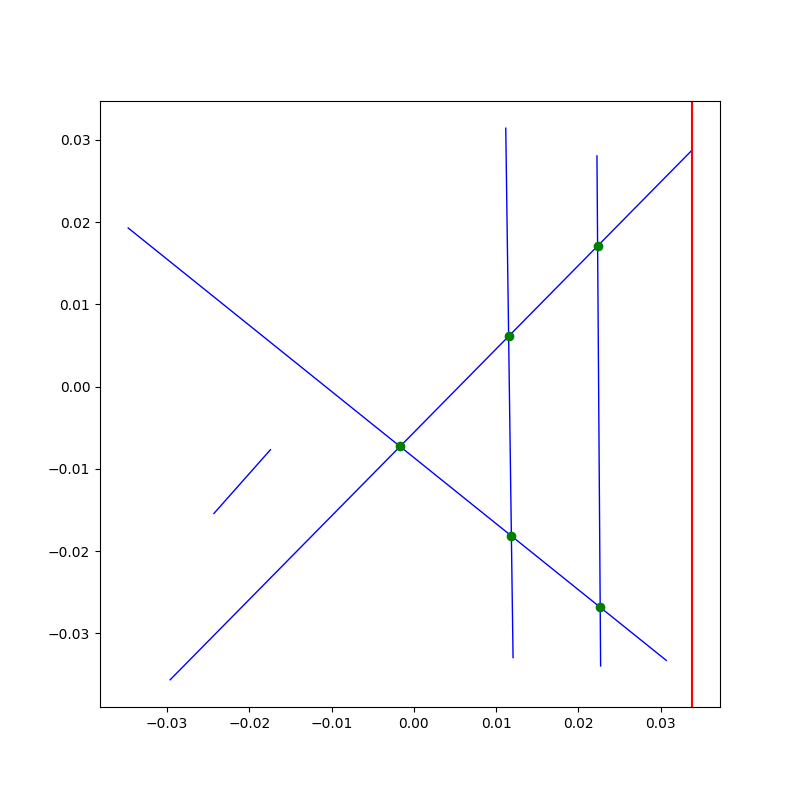

Passed
	Test 2: [((-0.04271371103102162, 0.007908498446146661), (0.004302418001236444, -0.03691380547542198)), ((-0.03384274328908614, 0.02509599844614667), (0.017165321227042896, -0.02848856037738276)), ((-0.011000001353602261, -0.017367236847970993), (0.030915321227042908, -0.015345178024441575)), ((0.002528224452849351, -0.03185865841659845), (0.02670161154962354, 0.0031903611912447033))]


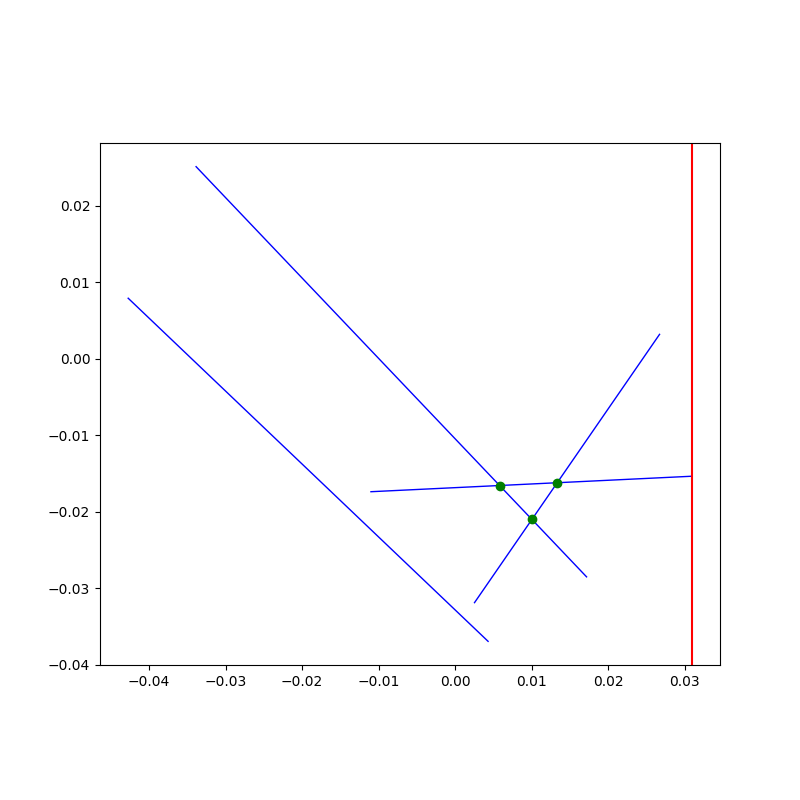

Passed
	Test 3: [((0.017165321227042896, 0.04471558346467863), (0.03468548251736549, -0.0014547596725763001)), ((-0.0019072594181183955, 0.030224161896051163), (0.02781048251736548, -0.0065099067313998255)), ((-0.0065645174826345215, 0.002589357974482537), (0.027588708323817088, -0.011228043986301783)), ((-0.003903227160053882, -0.0294265733980665), (0.028697579291559028, -0.020664318496105713)), ((-0.024306452966505486, -0.0122390733980665), (0.002971772839946124, -0.017631230260811592)), ((-0.020536291676182906, 0.0234839658176198), (0.002528224452849351, 0.010340583464678615)), ((-0.0327338723213442, -0.02875255379022336), (0.0009758050980106375, -0.03818882830002729)), ((-0.04271371103102162, -0.003813828300027272), (-0.018096775547150654, -0.00010672045689001652)), ((-0.04559677554715065, 0.036290338366639405), (-0.024306452966505486, 0.011688622680364885)), ((0.02226612767865581, -0.03919985771179199), (0.044665321227042906, -0.01965328908434101))]


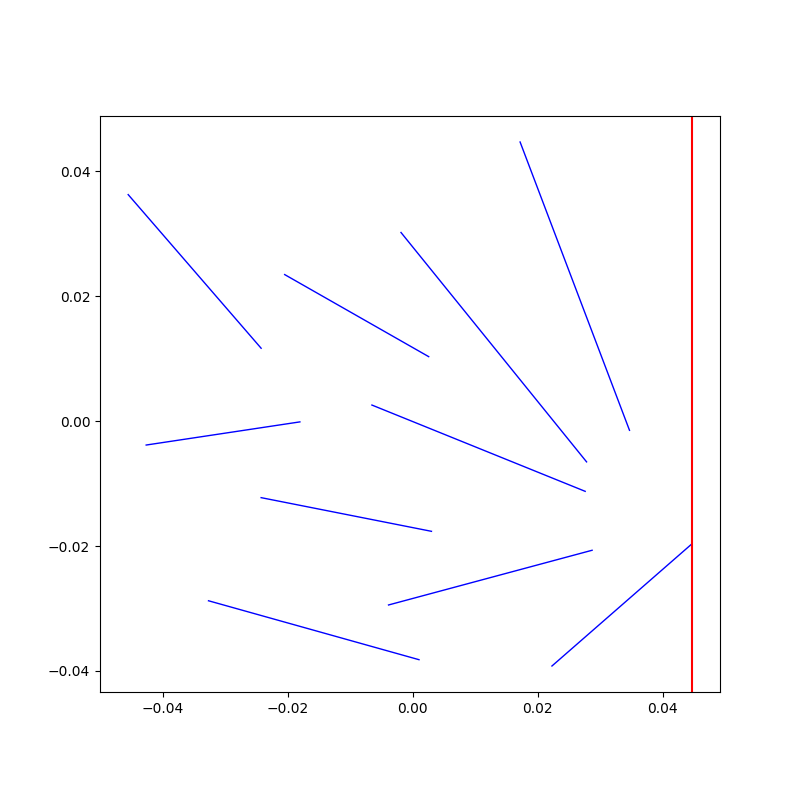

Passed
Result: 3/3
Time: 0.469s


Lab 4, task 3:
	Test 1: [((-0.034729840063279685, 0.019299425704806472), (0.030693547033494514, -0.03327410370695825)), ((-0.02962903361166678, -0.03563317233440923), (0.03379838574317193, 0.028735700214610402)), ((0.01117741800123645, 0.031431778645982955), (0.012064514775429996, -0.032937093903036674)), ((0.02226612767865581, 0.028061680606767267), (0.022709676065752582, -0.03394812331480138)), ((-0.024306452966505486, -0.015412584099115098), (-0.017431452966505487, -0.007661358608919019))]
Passed
	Test 2: [((-0.04271371103102162, 0.007908498446146661), (0.004302418001236444, -0.03691380547542198)), ((-0.03384274328908614, 0.02509599844614667), (0.017165321227042896, -0.02848856037738276)), ((-0.011000001353602261, -0.017367236847970993), (0.030915321227042908, -0.015345178024441575)), ((0.002528224452849351, -0.03185865841659845), (0.02670161154962354, 0.0031903611912447033))]
Passed
	Test 3: [((0.017165321227042896, 0.04471558346467863), (0.03468548251736549, -0.0014547596725763001

In [ ]:
E = 1e-18
D = 1e-6

def is_valid(section):
    return section.pr[0] != section.pl[0]

def find_intersections_brut(sections):
    n = len(sections)    
    result = []
    start = time()
    for i in range(n):
        for j in range(i+1, n):
            if(is_intersection(*sections[i], *sections[j])):
                result.append(get_intersection(sections[i],sections[j]))
    end = time()
    # draw_state(sections,[],[],result,(0,0))
    return result, end - start

def find_intersections(sections):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """
    print(sections)
    result = []
    answer = []
    handled = []
    # print(sections)
    segments = [LineSegment(Point(x1,y1,line_index=i),Point(x2,y2,line_index=i), index=i) for i, [(x1,y1), (x2,y2)] in enumerate(sections)]
    events = EventsStructure()
    checked = set()
    start = time()
    for s in segments:
        if is_valid(s):
            events.add_event(Point(s.pl.x,s.pl.y,s.index,PointType.START))
            events.add_event(Point(s.pr.x,s.pr.y,s.index,PointType.END))
    tree = RedBlackTree()
    while(len(events)>0):
        last = events.top()
        e = events.get_event()
        if e.point_type == PointType.START:
        # case PointType.START:
            tree.set_x(e.x)
            s = segments[e.line_index]
            tree.insert(s)
            prev, next_ = tree.find_previous_and_next_segment(s)
            events.add_cross_event(prev,s,checked)
            events.add_cross_event(s,next_,checked)
        # case PointType.END:
        elif e.point_type == PointType.END:
            # tree.set_x(e.x)
            s = segments[e.line_index]
            # After removal, the 
            prev, next_ = tree.find_previous_and_next_segment(s)
            events.add_cross_event(prev,next_,checked)
            tree.remove(s)
        # case PointType.CROSS:
        elif e.point_type == PointType.CROSS:
            first_index, second_index = e.line_index,e.other_line
            first_segment, second_segment = segments[first_index], segments[second_index]
            prev1, next1 = tree.find_previous_and_next_segment(first_segment)
            prev2, next2 = tree.find_previous_and_next_segment(second_segment)
            first_segment_upper_neighbour = prev1 if prev1 != second_segment else next1
            second_segment_lower_neighbour = prev2 if prev2 != first_segment else next2
            result.append(e)
            answer.append(f'{e.x} {e.y} {e.line_index} {e.other_line}')
            if first_segment != None:
                tree.remove(first_segment)
            if second_segment != None:
                tree.remove(second_segment)
                # print(tree.find_previous_and_next_segment(second_segment))
            moved_x = e.x + D
            tree.set_x(moved_x)
            new_first_segment = LineSegment(first_segment.pl,first_segment.pr,first_segment.index)
            new_second_segment = LineSegment(second_segment.pl,second_segment.pr,second_segment.index)
            tree.insert(new_first_segment)
            tree.insert(new_second_segment)
            events.add_cross_event(new_first_segment, second_segment_lower_neighbour, checked) 
            events.add_cross_event(new_second_segment, first_segment_upper_neighbour, checked) 
        handled.append(e)
    end = time()
    
    # draw_state(sections,[],events.mainHeap,result,last)
    # The segments in tests are numbered from 0, I had to add a 1
    return answer, end - start 

def is_he_stupid(sections):
    def stupidify(answer,crap):
        stupid_answer = []
        for point in answer:
            p1, p2, i , j =point.split(' ')
            stupid_answer.append(f"{p1} {p2} {chr(ord(i)+1)} {chr(ord(j)+1)}") 
        return stupid_answer
    return stupidify(*find_intersections(sections))
Test().runtest(3, is_he_stupid)

Uzupełnij funkcję ```find_intersections_with_visualization```

In [264]:
import matplotlib.pyplot as plt

def get_points(n):
    return [ (uniform(-10,10),uniform(-10,10)) for _ in range(n) ]



def find_intersections_with_visualization(sections):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """
    n = len(sections)
    # vis1 = Visualizer()
    # vis1.add_line_segment(sections, color = "green")
    interpoints = []
    points = [ p2 for _,p2 in sections ] + [ p1 for p1,_ in sections ] 
    for i in range(n):
        for j in range(i+1, n):
            print(is_intersection(sections[i], sections[j]))
            if(is_intersection(sections[i], sections[j])):
                x, y = get_intersection(sections[i], sections[j])
                interpoints.append((x, y))
            draw_state(sections,[sections[i],sections[j]],interpoints,points,interpoints[-1])
    print("\nWYNIKI DLA BRUTA:")
    for i in range(len(interpoints)):
        print('(', round(interpoints[i][0], 3), round(interpoints[i][1], 3), ')')
    print()

def draw_frame(sections, current,events,result_points, current_point, filename):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    dy = 1e-2
    # Wszystkie odcinki
    for section in sections:
        x_vals, y_vals = [section[0][0], section[1][0]], [section[0][1], section[1][1]]
        ax.plot(x_vals, y_vals, color='blue', zorder=1, lw=1)

    # Odcinki aktywne
    for section in current:
        print(section)
        x_vals, y_vals = [section[0][0], section[1][0]], [section[0][1], section[1][1]]
        ax.plot(x_vals, y_vals, color='red', zorder=2, lw=1)

    # Punkty zdarzeń
    for idx, (x, y,_) in enumerate(events):
        ax.scatter(x, y, color='red', zorder=1, label=f'Point {idx}' if idx == 0 else None)

    # Punkty obsłużone
    for idx, (x,y,_) in enumerate(result_points):
        ax.scatter(x, y, color='green', zorder=1, label=f'Point {idx}' if idx == 0 else None)

    if current_point != None:
        ax.axline((current_point.x,current_point.y),(current_point.x,current_point.y+dy), color='red', label="Miotła")

    ax.autoscale()
    plt.savefig(filename)
    plt.close()

def find_intersections_visualized(sections, gif_name='find_cuts.gif'):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """
    result = []
    handled = []
    segments = [LineSegment(Point(x1,y1,line_index=i),Point(x2,y2,line_index=i), index=i) for i, [(x1,y1), (x2,y2)] in enumerate(sections)]
    events = EventsStructure()
    checked = set()
    start = time()
    print(len(events.mainHeap))
    for s in segments:
        if is_valid(s):
            events.add_event(Point(s.pl.x,s.pl.y,line_index=s.index,point_type=PointType.START))
            events.add_event(Point(s.pr.x,s.pr.y,line_index=s.index,point_type=PointType.END))
    print(len(events.mainHeap))
    filenames = []
    # Należy wrzucić działający algorytm i dać save_frame() przy klatkach
    def save_frame():
        nonlocal filenames
        filename = f"frame_{len(filenames)}.png"
        draw_frame(sections,tree.to_array(),events.mainHeap, result, events.top() if len(events) > 0 else None, filename)
        filenames.append(filename)

    tree = RedBlackTree()
    while(len(events)>0):
        save_frame()
        last = events.top()
        e = events.get_event()
        if e.point_type == PointType.START:
        # case PointType.START:
            tree.set_x(e.x)
            # save_frame()
            s = segments[e.line_index]
            print(f"Adding section {s}")
            tree.insert(s)
            prev, next_ = tree.find_previous_and_next_segment(s)
            events.add_cross_event(prev,s,checked)
            events.add_cross_event(s,next_,checked)
            save_frame()
        # case PointType.END:
        elif e.point_type == PointType.END:
            tree.set_x(e.x)
            # save_frame()
            s = segments[e.line_index]
            # After removal, the 
            prev, next_ = tree.find_previous_and_next_segment(s)
            events.add_cross_event(prev,next_,checked)
            # save_frame()
            tree.remove(s)
            save_frame()
        # case PointType.CROSS:
        elif e.point_type == PointType.CROSS:
            tree.set_x(e.x)
            # save_frame()
            first_index, second_index = e.line_index,e.other_line
            first_segment, second_segment = segments[first_index], segments[second_index]
            prev1, next1 = tree.find_previous_and_next_segment(first_segment)
            prev2, next2 = tree.find_previous_and_next_segment(second_segment)
            first_segment_upper_neighbour = prev1 if prev1 != second_segment else next1
            second_segment_lower_neighbour = prev2 if prev2 != first_segment else next2
            result.append(e)
            if first_segment != None:
                print(f"Removing segment {first_segment}")
                print(tree.find_previous_and_next_segment(first_segment))
                tree.remove(first_segment)
            if second_segment != None:
                print(f"Removing segment {second_segment}")
                tree.remove(second_segment)
                print(tree.find_previous_and_next_segment(second_segment))
            moved_x = e.x + D
            tree.set_x(moved_x)
            # save_frame()
            new_first_segment = LineSegment(first_segment.pl,first_segment.pr,first_segment.index)
            new_second_segment = LineSegment(second_segment.pl,second_segment.pr,second_segment.index)
            tree.insert(new_first_segment)
            tree.insert(new_second_segment)
            # save_frame()
            events.add_cross_event(new_first_segment, second_segment_lower_neighbour, checked) 
            events.add_cross_event(new_second_segment, first_segment_upper_neighbour, checked) 
            handled.append(e)
            save_frame()
    save_frame()  # Stan początkowy
    images = [plt.imread(fname) for fname in filenames]
    plt.figure()
    plt.imshow(images[0])
    ani = animation.ArtistAnimation(plt.gcf(), [[plt.imshow(img)] for img in images], interval=500)
    ani.save(gif_name, writer='pillow')
    
    for fname in filenames:
        os.remove(fname)

    return result


# Wyznaczanie tabeli czasowych

In [276]:
points_set = [(generate_set_b,"Zbiór B")]
lengths = [ i for i in range(1000,10000,1000) ]


for generator, name in points_set:
    data = []
    for n in lengths:
        points = generator(n if name != "Zbiór B" else n)
        answer_brut, time_brut = find_intersections_brut(points)
        answer_sweepline, time_tree = find_intersections(points)
        print(f"{len(answer_brut)} {len(answer_sweepline)}")
        data.append({"segments":len(points) , "brut":time_brut*1000000, "tree":time_tree*1000000,"cuts":len(answer_brut)})
    create_tex_table("Wyniki",data) 

KeyboardInterrupt: 

0
10
Adding section ID: 0 SP: (-0.034729840063279685,0.019299425704806472) EP: (0.030693547033494514,-0.03327410370695825) a: -0.8035892323030909 b: -0.008609099809653579
ID: 0 SP: (-0.034729840063279685,0.019299425704806472) EP: (0.030693547033494514,-0.03327410370695825) a: -0.8035892323030909 b: -0.008609099809653579
ID: 0 SP: (-0.034729840063279685,0.019299425704806472) EP: (0.030693547033494514,-0.03327410370695825) a: -0.8035892323030909 b: -0.008609099809653579
Adding section ID: 1 SP: (-0.02962903361166678,-0.03563317233440923) EP: (0.03379838574317193,0.028735700214610402) a: 1.0148430001371183 b: -0.005564354972781797
ID: 0 SP: (-0.034729840063279685,0.019299425704806472) EP: (0.030693547033494514,-0.03327410370695825) a: -0.8035892323030909 b: -0.008609099809653579
ID: 0 SP: (-0.034729840063279685,0.019299425704806472) EP: (0.030693547033494514,-0.03327410370695825) a: -0.8035892323030909 b: -0.008609099809653579
Adding section ID: 4 SP: (-0.024306452966505486,-0.01541258409

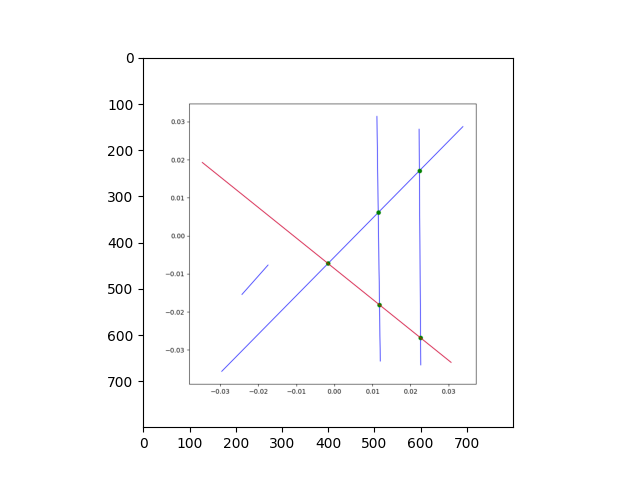

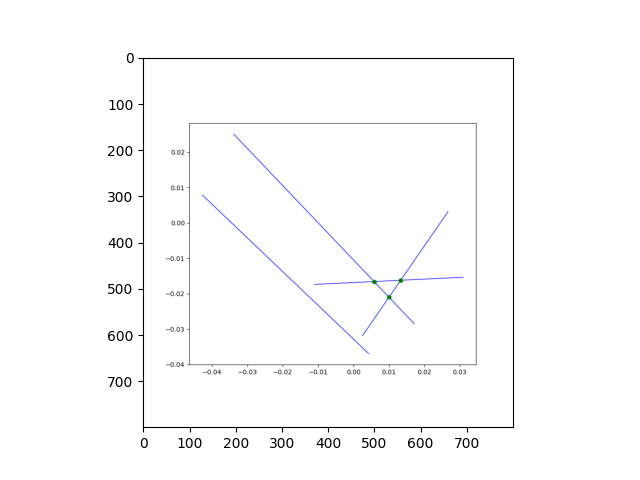

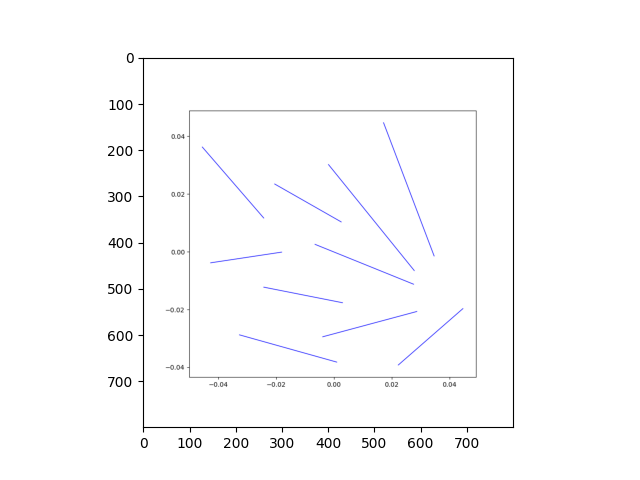

In [ ]:

def get_parameters(section):
    P1,P2 = section
    x1,y1,*_ = P1
    x2,y2,*_ = P2
    a = (y1-y2)/(x1-x2)
    b = y1 - a*x1
    return (a,b)
def get_intersection(section1,section2):
    a1,b1 = get_parameters(section1)
    a2,b2 = get_parameters(section2)
    x = (b1-b2)/(a2-a1)
    y = a1*x+b1
    return (x,y)
def find_intersections_brut_vis(sections):
    n = len(sections)    
    result = []
    start = time()
    segments = [LineSegment(Point(x1,y1,line_index=i),Point(x2,y2,line_index=i), index=i) for i, [(x1,y1), (x2,y2)] in enumerate(sections)]
    for i in range(n):
        for j in range(i+1, n):
            if(segments[i].intersects(segments[j])):
                result.append(get_intersection(segments[i],segments[j]))
    end = time()
    draw_state(sections,[],[],result,Point(0,0,None,PointType.START))
    return result

s1 = [((-0.034729840063279685, 0.019299425704806472), (0.030693547033494514, -0.03327410370695825)), ((-0.02962903361166678, -0.03563317233440923), (0.03379838574317193, 0.028735700214610402)), ((0.01117741800123645, 0.031431778645982955), (0.012064514775429996, -0.032937093903036674)), ((0.02226612767865581, 0.028061680606767267), (0.022709676065752582, -0.03394812331480138)), ((-0.024306452966505486, -0.015412584099115098), (-0.017431452966505487, -0.007661358608919019))]
s2 = [((-0.04271371103102162, 0.007908498446146661), (0.004302418001236444, -0.03691380547542198)), ((-0.03384274328908614, 0.02509599844614667), (0.017165321227042896, -0.02848856037738276)), ((-0.011000001353602261, -0.017367236847970993), (0.030915321227042908, -0.015345178024441575)), ((0.002528224452849351, -0.03185865841659845), (0.02670161154962354, 0.0031903611912447033))]
s3 = [((0.017165321227042896, 0.04471558346467863), (0.03468548251736549, -0.0014547596725763001)), ((-0.0019072594181183955, 0.030224161896051163), (0.02781048251736548, -0.0065099067313998255)), ((-0.0065645174826345215, 0.002589357974482537), (0.027588708323817088, -0.011228043986301783)), ((-0.003903227160053882, -0.0294265733980665), (0.028697579291559028, -0.020664318496105713)), ((-0.024306452966505486, -0.0122390733980665), (0.002971772839946124, -0.017631230260811592)), ((-0.020536291676182906, 0.0234839658176198), (0.002528224452849351, 0.010340583464678615)), ((-0.0327338723213442, -0.02875255379022336), (0.0009758050980106375, -0.03818882830002729)), ((-0.04271371103102162, -0.003813828300027272), (-0.018096775547150654, -0.00010672045689001652)), ((-0.04559677554715065, 0.036290338366639405), (-0.024306452966505486, 0.011688622680364885)), ((0.02226612767865581, -0.03919985771179199), (0.044665321227042906, -0.01965328908434101))]
test_sets = [(s1,"miklas_4_test_1"),(s2,"miklas_4_test_2"),(s3,"miklas_4_test_3")]
for ss, name in test_sets:
    find_intersections_visualized(ss,name + '.gif')


### Czy konieczne były zmiany w strukturze zdarzeń. Jeśli tak, to jakie? Czy w przypadku obu algorytmów konieczne są takie same struktury zdarzeń?
### Odpowiedź uzasadnij. 

W strukturze zdarzeń żadne zmiany nie były konieczne, ponieważ w taki sam sposób przechodzimy od punktu początkowego prostej do punktu końcowego


### Jak obsługiwane są zdarzenia początku odcinka, końca odcinka i przecięcia odcinków z uwzględnianiem wybranych struktur danych?

### Samemu zaprojektuj test, który uwzględnia taki układ odcinków, przy którym pewne przecięcia będą wykrywane więcej niż jeden raz

### Czy Twój program uwzględnia powyższy przypadek? Jeśli tak, to jak? 

### Zadanie dodatkowe
Zaimplementuj inną strukturę stanu. Opisz ją w sprawozdaniu. Porównaj efektywność algorytmu dla obu struktur robiąc testy na odpowiednio dużych zestawach odcinków.